# Feature extraction using VGG16

In [1]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

2023-04-14 11:14:03.569691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plotting function (from last week)

In [2]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Initialize the model

In [3]:
# load the model
model = VGG16()

553467096/553467096 [==============================] - 13s 0us/step


__Preprocessing__

Keras provides some tools to help with this step.

First, we can use the ```load_img()``` function to load the image and resize it to the required size of 224×224 pixels.

In [4]:
# load an image from file
image = load_img('../data/img/florence.jpg', target_size=(224, 224))
# Loading image with tensor flow beause it enables us to set the shape which we need our image to be (the image is automatically resized, if it doesn't fit the size from the beginning)

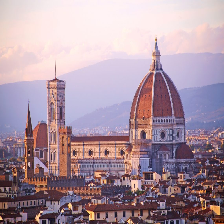

In [5]:
image

Next, we can convert the pixels to a NumPy array so that we can work with it in Keras. 

We can use the ```img_to_array()``` function for this.

In [6]:
# convert the image pixels to a numpy array
image = img_to_array(image)
# Note: this convertion sn't necessary when we load images with openCV

The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.

We only have one sample (one image). We can reshape the array by calling ```reshape()``` and adding the extra dimension.

In [7]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #the extra dimension "sample" (here 1) is added to make it 4D

Next, the image pixels need to be prepared in the same way as the ImageNet training data was prepared. Specifically, from the paper:

>The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. (Ross is not sure why)

See the paper [here](https://arxiv.org/abs/1409.1556).

In [8]:
# prepare the image for the VGG model
image = preprocess_input(image)

## Make prediction using ImageNet labels

We then use the model to predict our image class and convert probabilities to class labels using ```decode_predictions()```.

In [9]:
# predict the probability across all output classes
y_pred = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(y_pred)

35363/35363 [==============================] - 0s 1us/step


__Inspect most likely label__

In [10]:
label

[[('n03220513', 'dome', 0.45702526),
  ('n03028079', 'church', 0.301825),
  ('n03877845', 'palace', 0.04829808),
  ('n02930766', 'cab', 0.026109034),
  ('n02825657', 'bell_cote', 0.024095427)]]

## Finetune on new task

We import the regular cifar10 dataset from ```keras``` and normalise.

In [11]:
((X_train, y_train), (X_test, y_test)) = cifar10.load_data()
X_train = X_train.astype("float") / 255.
X_test = X_test.astype("float") / 255.

170498071/170498071 [==============================] - 7s 0us/step


__Binarize labels__

In [12]:
# integers to one-hot vectors
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# initialize label names for CIFAR-10 dataset
labelNames = ["airplane", "automobile", 
              "bird", "cat", 
              "deer", "dog", 
              "frog", "horse", 
              "ship", "truck"]

__Check tensor shape__

In [13]:
X_train.shape

(50000, 32, 32, 3)

__Load VGG16 *without* the classification layers__

Here we're just loading the convolutional layers and not the final classification network, using the argument ```include_top=False```

We also redefine the input shape, to work better with our cifar10 data.

In [14]:
# load model without classifier layers
model = VGG16(include_top=False, # the top layer is the classification part, which we don't want
              pooling='avg', # put in an average pooling layer instead of the classification layer
              input_shape=(32, 32, 3)) # change the way the model works so it can take images of the size which cifar_10 images have. 

58889256/58889256 [==============================] - 2s 0us/step


__Disable training of Conv layers__

We need to disable the convolutional layers before training. Why?

In [15]:
# mark loaded layers as not trainable
for layer in model.layers: 
    layer.trainable = False
# False --> for each layer in the model, freeze all the weights (som they aren't trainable any more).

In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Add new classification layers__

We now add new classification layers after the convolutional layers.

Notice how here we are not using the ```Sequential```, so we have to explicitly name the preceding layer in the model!

In [17]:
tf.keras.backend.clear_session()

In [18]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output) # layer that flattenes the data
class1 = Dense(128, activation='relu')(flat1) # our first classification layer
output = Dense(10, activation='softmax')(class1) # output layer with predictions
# flat1, class1, and output are individual layers
# the thing in the last paranthesis is the old/previous layer, to which the new layer is added. 

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Now we have added a small neural network with 66.954 new trainable weights. 

__Compile__

We're going to be using a more sophisticated optimization algorithm, which you can read about [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay).

In [19]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

In [20]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

__Train__

In [21]:
# Model is fitted to the training data
H = model.fit(X_train, y_train, 
            validation_split=0.1,
            batch_size=128,
            epochs=10,
            verbose=1)

Epoch 1/10
352/352 [==============================] - 220s 623ms/step - loss: 2.0143 - accuracy: 0.3074 - val_loss: 1.7976 - val_accuracy: 0.4048
Epoch 2/10
352/352 [==============================] - 218s 620ms/step - loss: 1.7225 - accuracy: 0.4173 - val_loss: 1.6195 - val_accuracy: 0.4538
Epoch 3/10
352/352 [==============================] - 220s 625ms/step - loss: 1.5957 - accuracy: 0.4569 - val_loss: 1.5292 - val_accuracy: 0.4800
Epoch 4/10
352/352 [==============================] - 221s 628ms/step - loss: 1.5239 - accuracy: 0.4777 - val_loss: 1.4723 - val_accuracy: 0.5016
Epoch 5/10
352/352 [==============================] - 221s 627ms/step - loss: 1.4764 - accuracy: 0.4912 - val_loss: 1.4386 - val_accuracy: 0.5024
Epoch 6/10
352/352 [==============================] - 223s 633ms/step - loss: 1.4415 - accuracy: 0.5047 - val_loss: 1.4011 - val_accuracy: 0.5194
Epoch 7/10
352/352 [==============================] - 221s 629ms/step - loss: 1.4139 - accuracy: 0.5119 - val_loss: 1.3823 -

__Evaluate__

/tmp/ipykernel_1208/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


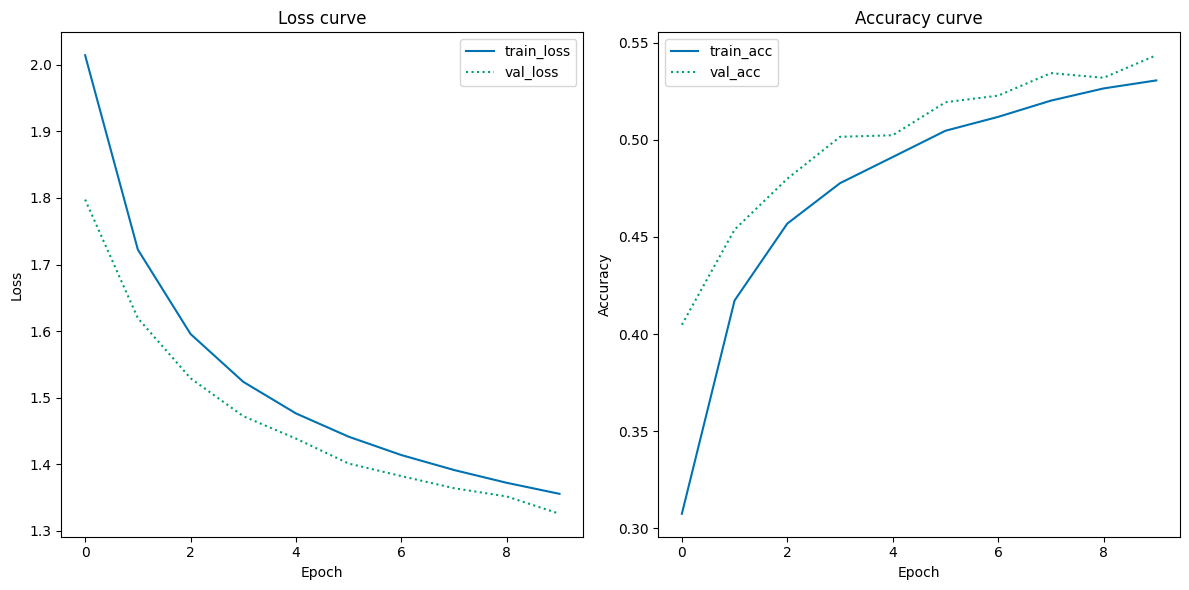

In [22]:
plot_history(H, 10)
# tgraphs: he model is doing alright

In [23]:
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

79/79 [==============================] - 44s 561ms/step
              precision    recall  f1-score   support

    airplane       0.57      0.59      0.58      1000
  automobile       0.53      0.61      0.57      1000
        bird       0.46      0.34      0.39      1000
         cat       0.38      0.40      0.39      1000
        deer       0.52      0.47      0.50      1000
         dog       0.46      0.51      0.48      1000
        frog       0.56      0.64      0.59      1000
       horse       0.55      0.58      0.56      1000
        ship       0.62      0.64      0.63      1000
       truck       0.57      0.44      0.50      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000



## Using data augmentation

__Reload model__

In [24]:
del model
tf.keras.backend.clear_session()

In [25]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output) # flatten the images
bn = BatchNormalization()(flat1) # batch normalization layer (normalizes values from the previous layer)
class1 = Dense(256, 
               activation='relu')(bn)
class2 = Dense(128, 
               activation='relu')(class1)
output = Dense(10, 
               activation='softmax')(class2)
# the only two things added to the model we use earlier in the script is adding an extra classification layer of 256, and adding batchnormalization layer. 

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Define data generator__

You can see the documentation for ImageDataGenerator [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [28]:
# flip along x axis (mirror image)
datagen = ImageDataGenerator(horizontal_flip=True, # flip some images across the x-axes
                             rotation_range=20, # randomly rotate some images 20 degrees
                             validation_split=0.1) # 10% of the data is valiadtion data

We're choosing to generate data on the fly, rather than save it to a folder.

__Train__

In [29]:
# fit the data generator to our images
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
H = model.fit(datagen.flow(X_train, y_train, batch_size=128), 
              validation_data = datagen.flow(X_train, y_train, batch_size=128, subset = "validation"),
            epochs=10)

# the data is streamed from the folder, where it is, instead of downloading all the data into the model. 

Epoch 1/10


2023-04-14 13:06:52.094836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


391/391 [==============================] - ETA: 0s - loss: 1.9434 - accuracy: 0.3121

2023-04-14 13:10:38.021920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


391/391 [==============================] - 248s 633ms/step - loss: 1.9434 - accuracy: 0.3121 - val_loss: 1.7009 - val_accuracy: 0.4170
Epoch 2/10
391/391 [==============================] - 249s 637ms/step - loss: 1.5950 - accuracy: 0.4442 - val_loss: 1.5128 - val_accuracy: 0.4676
Epoch 3/10
391/391 [==============================] - 245s 628ms/step - loss: 1.4758 - accuracy: 0.4848 - val_loss: 1.4298 - val_accuracy: 0.4958
Epoch 4/10
391/391 [==============================] - 249s 636ms/step - loss: 1.4059 - accuracy: 0.5078 - val_loss: 1.3573 - val_accuracy: 0.5220
Epoch 5/10
391/391 [==============================] - 249s 636ms/step - loss: 1.3631 - accuracy: 0.5223 - val_loss: 1.3236 - val_accuracy: 0.5306
Epoch 6/10
391/391 [==============================] - 243s 621ms/step - loss: 1.3305 - accuracy: 0.5335 - val_loss: 1.2993 - val_accuracy: 0.5458
Epoch 7/10
391/391 [==============================] - 249s 636ms/step - loss: 1.3045 - accuracy: 0.5422 - val_loss: 1.2650 - val_accura

__Inspect__

/tmp/ipykernel_1208/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


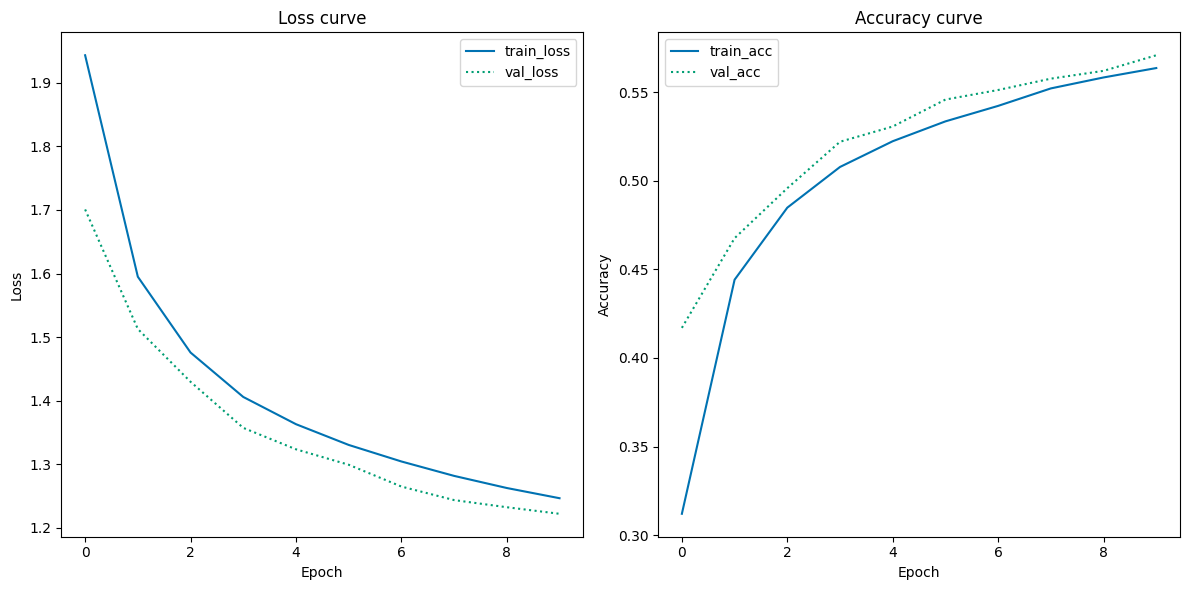

In [30]:
plot_history(H, 10)

__Evaluate__

In [33]:
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

79/79 [==============================] - 43s 550ms/step
              precision    recall  f1-score   support

    airplane       0.59      0.69      0.64      1000
  automobile       0.57      0.67      0.62      1000
        bird       0.53      0.45      0.49      1000
         cat       0.43      0.41      0.42      1000
        deer       0.58      0.44      0.50      1000
         dog       0.56      0.47      0.51      1000
        frog       0.55      0.71      0.62      1000
       horse       0.62      0.63      0.62      1000
        ship       0.70      0.64      0.67      1000
       truck       0.56      0.56      0.56      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.57      0.57      0.56     10000

